# Text Summarisation: Using Hugging Face's Pipeline To Summarise Short and Long Speeches

Text summarization is a far less common downstream NLP task compared to, say, classification or sentiment analysis. The resources and time needed to do it well are considerable, to say nothing of the time needed to assess the results.

Hugging Face's transformers pipeline, however, has made the first part of the task much faster and efficient. More time can then be devoted to analysing the results, and/or building your own benchmarks for assessing the summaries.

Due to the sequence length limits (eg, 1024 tokens for BART and 512 for T5 in the pipeline), a little additional work is needed to break up long speeches. I find this a better approach in any case as it allows me to better inspect the results more closely. More advanced models in future (GPT-3?) could render this step redundant.

Results-wise, the summaries can range from so-so to being spot on, as the examples below will show. There are mistakes too, and some parts of the output are obviously nonsensical if you understand the context of some speeches (less so if you don't).

But overall, I'd say that the results present a very good first draft, especially in summarizing longer speeches. I can see decent applications of this in newsrooms, for one. It'll be interesting to see how well the models perform on this task as they get more sophisticated.

This is the second of a series of notebooks focusing on practical applications of new NLP tools. My earlier notebook on analysing the sentiment structure of speeches (also using Hugging Face's pipeline) can be found [here](https://github.com/chuachinhon/practical_nlp/blob/master/notebooks/1.0_speech_sentiment_cch.ipynb).

In [2]:
from __future__ import print_function

import ipywidgets as widgets
import pandas as pd
import re

from transformers import pipeline

# 1. DATA PROCESSING

For this notebook, I'm using a small collection of political speeches/statements made during Singapore's General Election in July 2020. The word-count for the speeches in this toy dataset ranges from 236 words to 3,746 words.

Feel free to switch out to speeches from other countries, or point in history. If you are applying this to speeches from specialised areas like law or medicine, you'll likely have to fine tune it with domain-specific data.

Point to note: This doesn't work for non-English speeches.

In [3]:
raw = pd.read_csv("../data/ge2020_speeches.csv")

In [4]:
# Adding a word-count column for easier reference

raw['Word_Count'] = raw['Text'].str.count(' ') + 1

In [5]:
# Simple cleaning of text ahead of summarisation

def clean_text(text):
    text = text.encode("ascii", errors="ignore").decode("ascii") #remove non-ascii, Chinese characters
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"\n", " ", text)
    text = re.sub(r"\n\n", " ", text)
    text = re.sub(r"\W", " ", text)
    text = re.sub(r"^\d+\s|\s\d+\s|\s\d+$", " ", text)
    text = text.strip(" ")
    text = re.sub(r"[^\w\s]", "", text)
    text = re.sub(' +',' ', text).strip() # get rid of multiple spaces and replace with a single
    return text

raw["Clean_Text"] = raw['Text'].map(lambda text: clean_text(text))

In [6]:
raw.head(11)

Date                     Party          Speaker  \
0   2020-06-23     People's Action Party  Lee Hsien Loong   
1   2020-06-24  Progress Singapore Party   Lee Hsien Yang   
2   2020-06-25            Workers' Party     Pritam Singh   
3   2020-06-27     People's Action Party  Lee Hsien Loong   
4   2020-06-29  Progress Singapore Party   Lee Hsien Yang   
5   2020-06-30  Progress Singapore Party   Lee Hsien Yang   
6   2020-06-30            Workers' Party     Pritam Singh   
7   2020-06-30     People's Action Party  Lee Hsien Loong   
8   2020-07-01     People's Action Party  Lee Hsien Loong   
9   2020-07-05  Progress Singapore Party   Lee Hsien Yang   
10  2020-07-06     People's Action Party  Lee Hsien Loong   

                                       Title  \
0                        GE2020 announcement   
1                                    FB post   
2                                    FB post   
3                    Launch of PAP manifesto   
4                                        NaN   
5              POLITICS IS FOR EVERY CITIZEN   
6   Make Your Vote Count: Message for voters   
7                           Letter to voters   
8                          Message to voters   
9                      CHARACTER AND COURAGE   
10                Fullerton Lunch time Rally   

                                                 Text  \
0   Earlier today, I saw President Halimah Yacob, ...   
1   Election fever is in the air.\n\nThe coming Ge...   
2   I would like to announce that Mr Low Thia Khia...   
3   We are going into elections in the midst of a ...   
4   SINGAPORE WANTS DIFFERENT\nSingaporeans will h...   
5   You may not be interested in politics, but pol...   
6   This election is taking place amidst extraordi...   
7   COVID-19 is the most severe crisis for humanit...   
8   This General Election is critical for our futu...   
9   This election year, Singapore is seeing a surg...   
10  In almost every General Election since indepen...   

                                                  URL  Word_Count  \
0   https://www.pmo.gov.sg/Newsroom/Speech-on-GE20...        1283   
1   https://www.facebook.com/watch/?v=173190043697...         236   
2   https://www.facebook.com/pritam.eunos/posts/32...         463   
3   https://www.straitstimes.com/politics/singapor...        2181   
4   https://www.facebook.com/LeeHsienYangSGP/video...         785   
5   https://www.facebook.com/LeeHsienYangSGP/posts...         591   
6               https://www.wp.sg/message-for-voters/         627   
7   https://prodwpbolb.blob.core.windows.net/media...         287   
8   https://www.pap.org.sg/news/ge2020-news/messag...        1732   
9   https://www.facebook.com/LeeHsienYangSGP/posts...         510   
10  https://www.pap.org.sg/news/ge2020-news/ge2020...        3746   

                                           Clean_Text  
0   earlier today i saw president halimah yacob to...  
1   election fever is in the air the coming genera...  
2   i would like to announce that mr low thia khia...  
3   we are going into elections in the midst of a ...  
4   singapore wants different singaporeans will ha...  
5   you may not be interested in politics but poli...  
6   this election is taking place amidst extraordi...  
7   covid is the most severe crisis for humanity i...  
8   this general election is critical for our futu...  
9   this election year singapore is seeing a surge...  
10  in almost every general election since indepen...

## 1.1 SELECT SHORT SPEECHES

The short speeches (less than 1024 tokens) can be efficiently summarised at one go using the HF pipeline, while the longer ones will take a bit of extra work. So let's split out the short speeches first. 

In [7]:
crit1 = raw["Word_Count"] < 800

short_speeches = raw[crit1].copy()

## 1.2 SELECT A LONG SPEECH

To keep this notebook consise, I'll just focus on the longest speech (3,746 words) in my sample dataset. The extra work-around is merely to break the speech up into chunks of fixed-character length.

The function below (taken from this [Stack Overflow post](https://stackoverflow.com/questions/47625950/split-string-by-spaces-into-substrings-with-max-length-in-python)) allows you to cut the text up into smaller or bigger chunks as you wish. I picked the chracter-length split setting of 2500 for convenience.

In [8]:
long_speech = raw[10:].copy()

In [9]:
# Define function to split cleaned text into fixed chunks of user-defined length
# In this case, we'll split into chunks of 2500 characters each; feel free to change for your own tests

def split_text(text, limit, sep=" "):
    words = text.split()
    if max(map(len, words)) > limit:
        raise ValueError("limit is too small")
    res, part, others = [], words[0], words[1:]
    for word in others:
        if len(sep)+len(word) > limit-len(part):
            res.append(part)
            part = word
        else:
            part += sep+word
    if part:
        res.append(part)
    return res

long_speech['Split_Text'] = long_speech['Clean_Text'].map(lambda x: split_text(x, limit=2500)).copy()

In [10]:
# Creating a new DF from the chunks which have been split up

long_speech_split = (
    pd.DataFrame(long_speech['Split_Text'].explode())
    .stack()
    .reset_index()
    .rename(columns={0: "Sections"})
    .drop(["level_0", "level_1"], axis=1)
)

In [11]:
# 9 sections looks like a decent split for a 3,700+ words speech
# This gives us enough scope to test the model's performance, 
# while not making it too troublesome to inspect the results

long_speech_split

Sections
0  in almost every general election since indepen...
1  recruited and trained swab teams to perform th...
2  together on all these different aspects we wou...
3  deadlines because of the circuit breaker would...
4  with edb on a marketing pitch all over the wor...
5  elected in a crisis where swift decisive actio...
6  better please vote for us if you think we have...
7  more than its old splendour the singapore rive...
8  agreed all my life i have felt a deep personal...

# 2. TEXT SUMMARY WITH HUGGING FACE'S PIPELINE

The heavy lifting has been done by the good people at HF, and you just need a few lines of code to start generating results. I'm using the summarisation pipeline out of the box, meaning it is using the default bart-large-cnn model. No additional tuning was done for Singapore politics or news.

We'll start with the short speeches. This could take longer or shorter depending on your machine. I used a late-2015 iMAC with 32Gb RAM.  

## 2.1 SUMMARIZING SHORT SPEECHES

In [12]:
corpus_short = list(short_speeches['Clean_Text'].values)

In [13]:
nlp_summarizer = pipeline(
    "summarization"
)

In [14]:
%%time

short_speeches["Summary"] = nlp_summarizer(corpus_short)

CPU times: user 4min 13s, sys: 12.9 s, total: 4min 26s
Wall time: 1min 4s


In [15]:
# The pipeline's sentiment analysis output consists of a label and the summarised text
# I prefer to extract the text into a separate column

short_speeches['HF_Summary_Text'] = [x.get('summary_text') for x in short_speeches['Summary']]

In [16]:
cols1 = [
    "Date",
    "Party",
    "Speaker",
    "Title",
    "Text",
    "HF_Summary_Text",
    "Word_Count",
    "URL",
]

hf_short = short_speeches[cols1].copy()


In [17]:
# Uncomment and inspect the detailed results in CSV if you wish

# hf_short.to_csv("../data/short_results.csv", index=False)

In [18]:
# Let's have a quick look at the results from 7 summaries

hf_short['HF_Summary_Text'].values

array([' election fever is in the air the coming general election will be a watershed there will be no lky bonus or sg to help the ruling party. There are a number of live issues which are of broad concern including thecpf scheme hdb leases and the presidential election widely perceived to lack legitimacy. The progress singapore party and dr tan needs our help we can contribute in many different ways.',
       'i would like to announce that mr low thia khiang, mr chen show mao and mr png eng huat would not be standing as candidates in ge2020. The decision to step down is not a retirement the collective decision is based on three considerations all of which are anchored on the continued political success of the workers party.',
       'Singaporeans will have to go out to vote on july when they would have preferred to stay safe from the risk of getting covid. Almost three months after lockdown began new cases still remain stubbornly in the three digit range a result of the paps poor hand

## QUICK TAKE

Some of the summaries are so-so. There's a tendency for the model to use the first and second sentences in the corpus. This could work well for summaries of news stories, but less so for those involving political/corporate speeches.

But the model turned up one brilliant summary, the fifth one where Workers' Party leader Pritam Singh laid out his party's main pitch to voters. See the original statement [here](https://www.wp.sg/message-for-voters/).

In 59 words, the Bart model perfectly distilled the essence of the Workers' Party's campaign message from a 627-word statement. Pretty striking for a model that has not been tuned on data involving Singapore politics.

Here's a side-by-side comparison of the original text and the Bart summary. Impressive, most impressive.

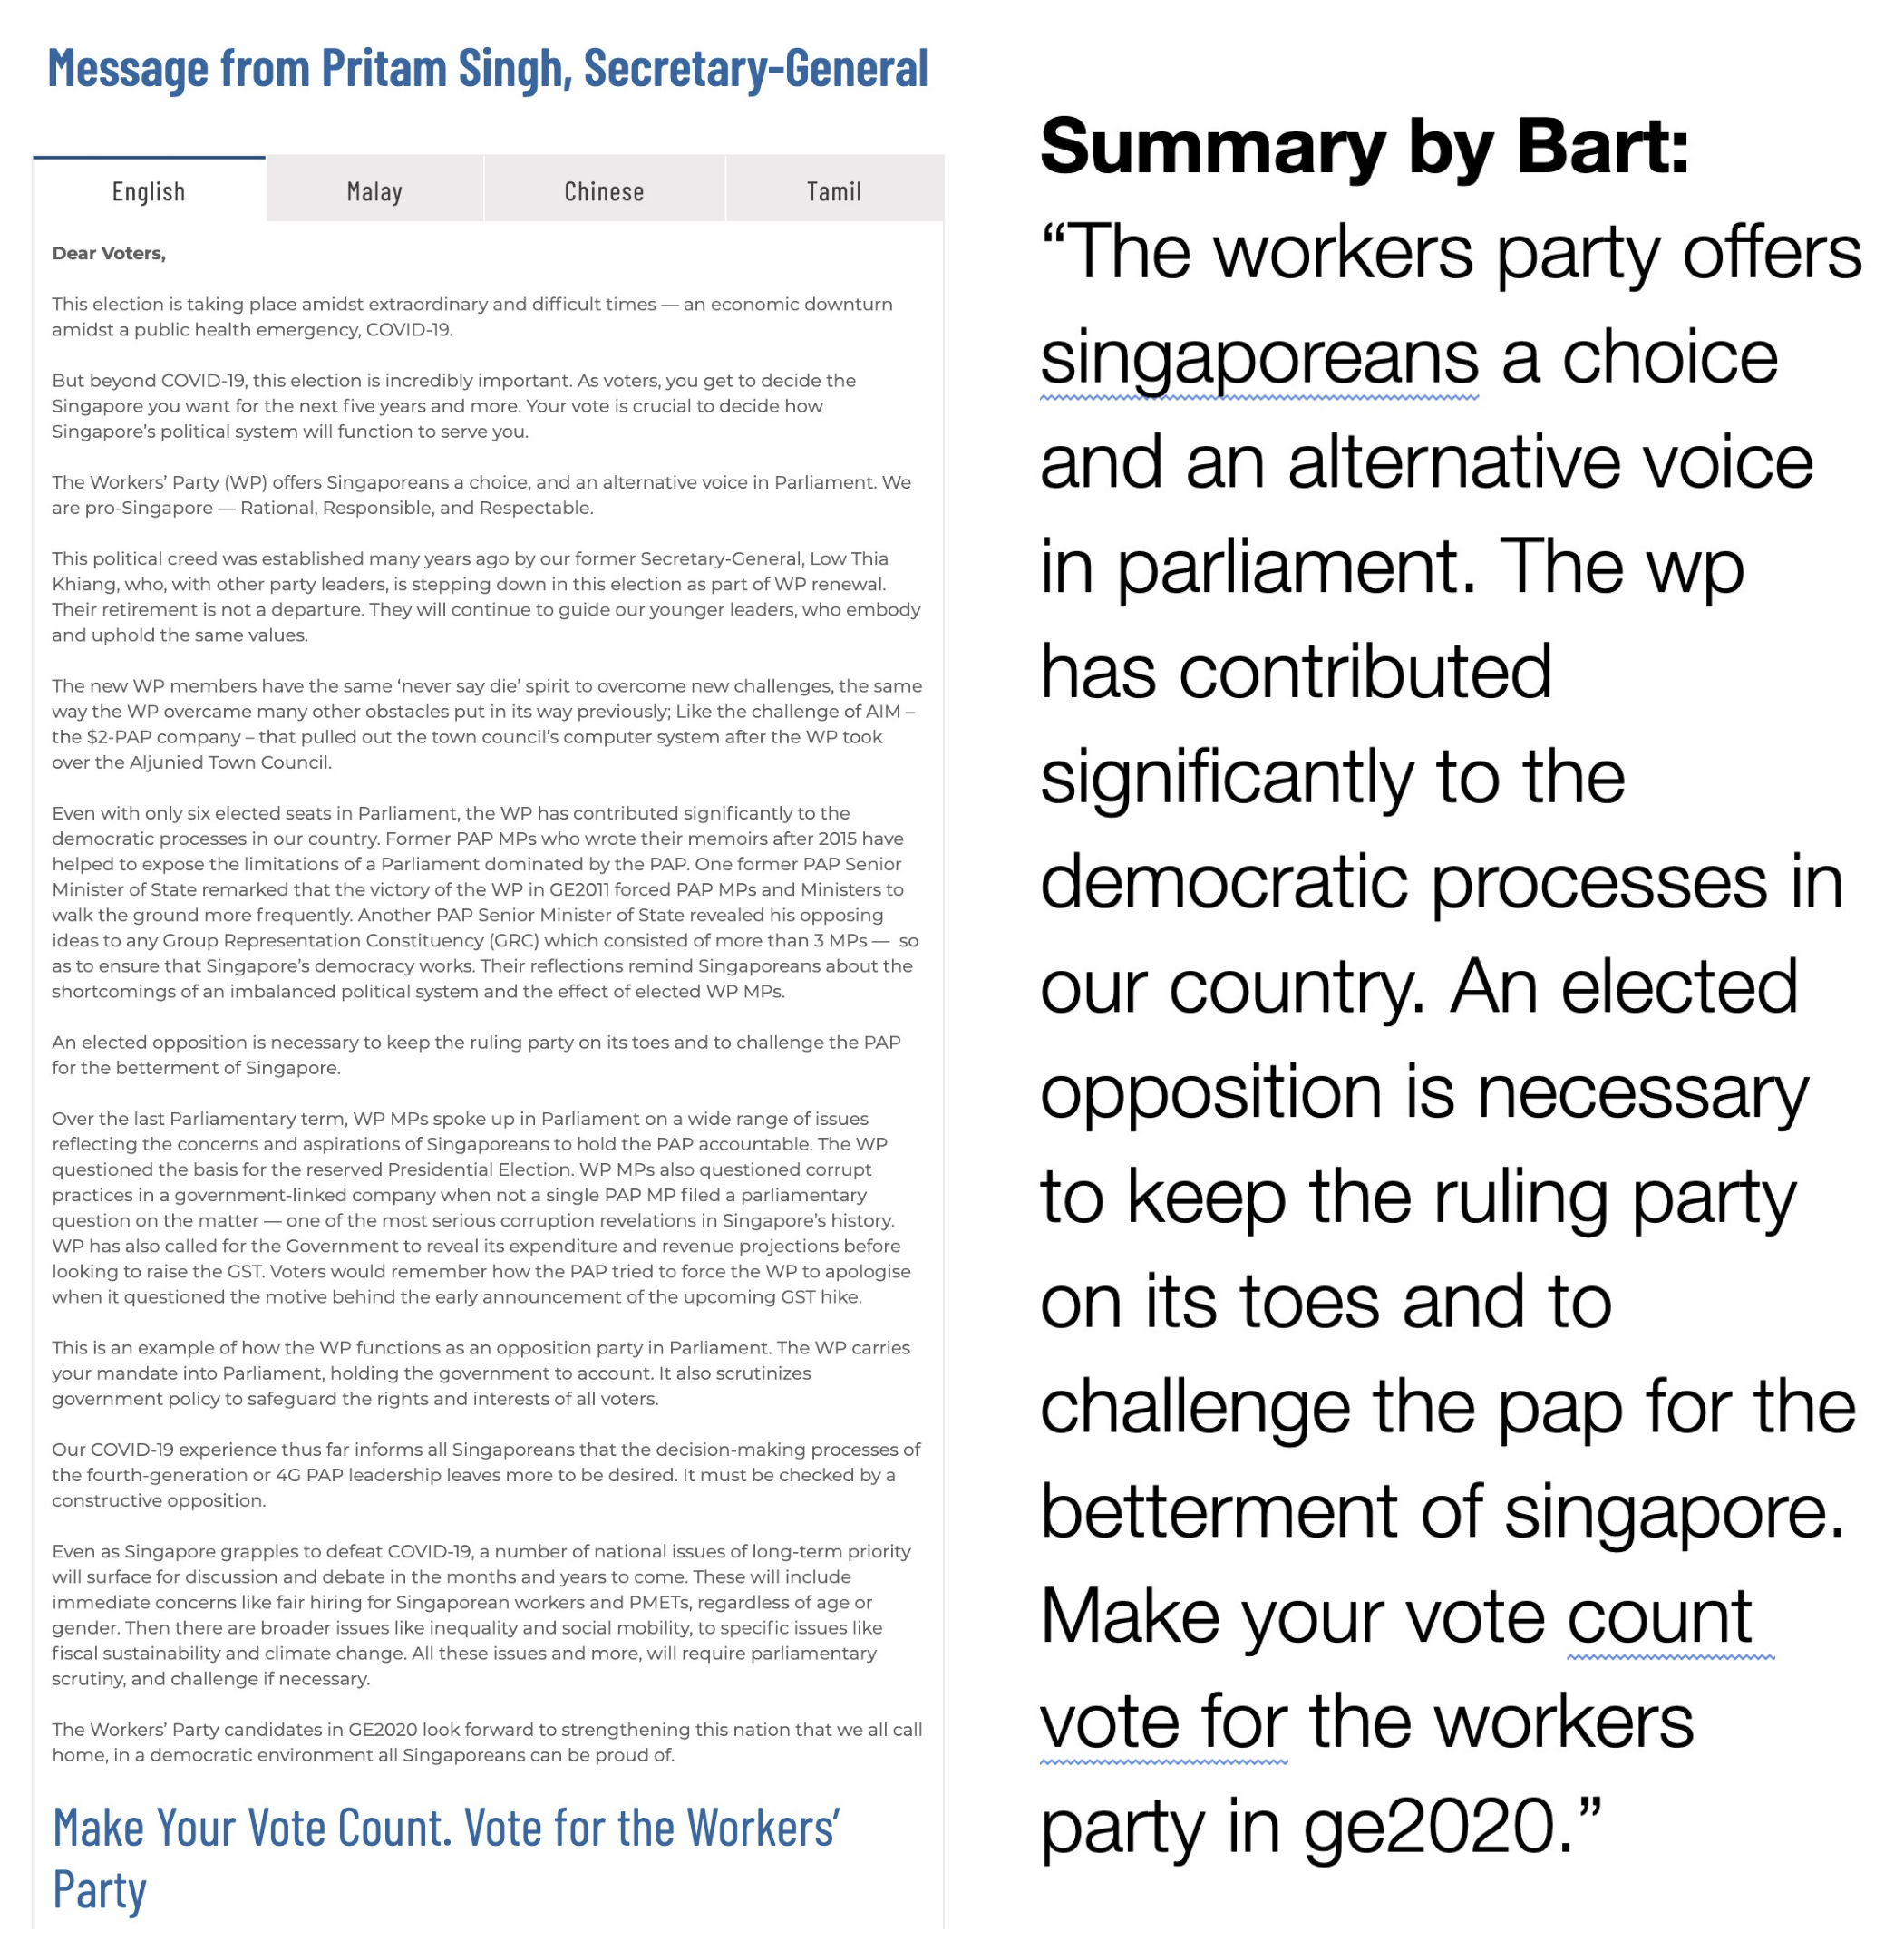

## 2.2 SUMMARIZE A LONG SPEECH

Next, let's see how Bart does with a long speech. 

In [19]:
corpus_long = list(long_speech_split['Sections'].values)

In [20]:
%%time

long_speech_split["Summary"] = nlp_summarizer(corpus_long)

CPU times: user 4min 21s, sys: 13.1 s, total: 4min 34s
Wall time: 1min 3s


In [21]:
long_speech_split['HF_Summary_Text'] = [x.get('summary_text') for x in long_speech_split['Summary']]

In [22]:
# Uncomment and inspect the detailed results in CSV if you wish

#long_speech_split.to_csv('../data/long_speech_results.csv', index=False)

In [23]:
# Let's have a look at how the 'mini-summaries' have turned out
# Overall, we have a 536-word summary of the original 3,746-word speech 

long_speech_split['HF_Summary_Text'].values

array(['Covid is a continuing danger to public health it will also weigh heavily on the economy for perhaps a year if not longer. A good government is to fight covid supporting the economy and get out of this crisis intact. This is what this election is aboutwhom do you trust to get you through the very difficult times ahead covid',
       'Despite our best efforts in april the virus broke out in our migrant worker dormitories the large numbers posed a real risk of overwhelming our hospitals we had to mount a huge operation. recruited and trained swab teams to perform the thousands of swabs needed every day behind the scenes this was a highly complex operation.',
       'Singapore has avoided the worst of the pandemic and is in a better position now. But the danger is still very much alive in many countries after lockdowns were relaxed cases have flared up again. The opposition parties are talking as if we can just keep to our old ways and the crisis did not exist.',
       'Ministers 

## QUICK TAKE

Not as the brilliant as the highlighted example above, but a pretty decent first draft I'll have to say. Key points were decently captured. If I'm in a rush, this is something I can clean up fairly quickly.

Singaporean users will pick out an obvious mistake in the summary of the 6th section: "Pap Lee Kuan Yew seeks not just your mandate but your strong mandate to lead singapore through this crisis."

The original paragraph reads: "Investors will scrutinise the election results, and act on their conclusions. So will others, both friends and adversaries of Singapore. That is why in this election, the PAP seeks not just your mandate, but your strong mandate, to lead Singapore through this crisis."

Lee Kuan Yew, Singapore's founding prime minister, [died in March 2015](https://en.wikipedia.org/wiki/Lee_Kuan_Yew). Those with more than a passing knowledge of Singapore politics might flippantly argue that Bart was in fact correct, and not erroneous with the above summary mentioning Lee Kuan Yew. But this is a discussion for another day ;)

Here's the link to the [original speech](https://www.pap.org.sg/news/ge2020-news/ge2020-lunch-time-rally/), and here's a side-by-side comparison. I've marked out the 'problematic' sentence.

## 2.3 SUMMARIZE WITH A DIFFERENT MODEL

HF has a growing list of models that are fine-tuned for the [summarization task](https://huggingface.co/models?filter=summarization). Whether they turn out better results is pretty much a case of trial-end-error.

I'll just try the t5-base model here, to see how it performs on the same 3,746-word speech used in Section 2.2. Since t5 has a lower max sequence limit, I'll try it on the shorter speeches/statements only

In [24]:
crit2 = raw["Word_Count"] < 500

shorter_speeches = raw[crit2].copy()

In [25]:
shorter_speeches

Date                     Party          Speaker             Title  \
1  2020-06-24  Progress Singapore Party   Lee Hsien Yang           FB post   
2  2020-06-25            Workers' Party     Pritam Singh           FB post   
7  2020-06-30     People's Action Party  Lee Hsien Loong  Letter to voters   

                                                Text  \
1  Election fever is in the air.\n\nThe coming Ge...   
2  I would like to announce that Mr Low Thia Khia...   
7  COVID-19 is the most severe crisis for humanit...   

                                                 URL  Word_Count  \
1  https://www.facebook.com/watch/?v=173190043697...         236   
2  https://www.facebook.com/pritam.eunos/posts/32...         463   
7  https://prodwpbolb.blob.core.windows.net/media...         287   

                                          Clean_Text  
1  election fever is in the air the coming genera...  
2  i would like to announce that mr low thia khia...  
7  covid is the most severe crisis for humanity i...

In [26]:
corpus_shorter = list(shorter_speeches['Clean_Text'].values)

In [27]:
t5_summarizer = pipeline(
    "summarization",
    model="t5-base",
    tokenizer="t5-base",
    framework="tf"
)

In [28]:
%%time

shorter_speeches["T5_Summary"] = t5_summarizer(corpus_shorter)

CPU times: user 2min 26s, sys: 10.8 s, total: 2min 37s
Wall time: 42.4 s


In [29]:
shorter_speeches['T5_Summary_Text'] = [x.get('summary_text') for x in shorter_speeches['T5_Summary']]

In [30]:
cols2 = [
    "Date",
    "Party",
    "Speaker",
    "Title",
    "Text",
    "T5_Summary_Text",
    "Word_Count",
    "URL",
]

t5_short = shorter_speeches[cols2].copy()

In [31]:
# Let's have a full at the results from t5

t5_short['T5_Summary_Text'].values

array(['there will be no lky bonus or sg to help the ruling party there are live issues of broad concern including the cpf scheme hdb leases and the presidential election widely perceived to lack legitimacy . the progress singapore party and dr tan needs our help we can contribute in many different ways . we can help to spread the word persuade our friends and family that the psp is a serious party that deserves their support .',
       'gerald giam and leon perera both experienced ncmps will stand in aljunied grc and the party organising secretary dennis tan another npmp will stand at hougang smc . mr low thia khiang ms low chen show mao and mmr png eng huat will not be standing as candidates in ge2020 the collective decision is based on three considerations all of which are ',
       'covid is the most severe crisis for humanity in a very long time every singaporean has been affected by the pandemic my government has spared no effort to support workers businesses and households we ha

## QUICK TAKE

The t5 results aren't better, unfortunately. But more pre-trained models are coming online, and I can only imagine that the results can only get better with time. 